Task 1: Data Preparation & Multi-Label Text Classification


In [22]:
#imports for data analysis, visualization, etc

import pandas as pd
import numpy as np
from google.colab import drive
import json
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
#get required nltk resources for nlp
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [44]:
#creation of domain knowledge dictionary
domain_knowledge = {
    "competitors": [
        "Tupac Solutions", "MosDef Analytics", "BiggyCorp",
        "KDot Technologies", "JCole Corporation", "Nas and Co"
    ],
    "features": [
        "analytics", "AI", "data pipeline", "machine learning",
        "predictive modeling", "real-time reporting", "Big data",
        "Regression and classification", "Natural language processing"
    ],
    "pricing_keywords": [
        "discount", "renewal cost", "budget", "pricing model",
        "cost-effective", "ROI", "constraints", "shareholder value", "profitability"
    ],
    "security_keywords": [
        "CISSP", "CISA", "CISM", "CompTIA Security+",
        "GSEC", "SSCP", "CASP+", "GCIH"
    ],
    "pain_points": [
        "inefficient process", "data silos", "lack of insights",
        "manual reporting", "scalability issues", "integration challenges"
    ],
    "objection_keywords": [
        "too expensive", "not sure", "budget constraints",
        "need approval", "complex implementation", "vendor lock-in"
    ],
    "decision_maker_roles": [
        "CTO", "CIO", "CEO", "CFO", "VP of Technology",
        "Head of Data", "Chief Data Officer", "IT Director"
    ],
    "success_indicators": [
        "increased efficiency", "cost savings", "improved decision-making",
        "competitive advantage", "streamlined operations"
    ],
    "industry_verticals": [
        "finance", "healthcare", "tech", "retail",
        "manufacturing", "telecommunications", "education"
    ],
    "purchasing_signals": [
        "evaluating solutions", "current contract expiring",
        "seeking improvements", "looking for alternatives"
    ],
    "technical_concerns": [
        "data security", "compliance", "scalability",
        "integration", "performance", "reliability"
    ]
}

#Removal of stop words and lemmatization using nltk
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print(domain_knowledge)

{'competitors': ['Tupac Solutions', 'MosDef Analytics', 'BiggyCorp', 'KDot Technologies', 'JCole Corporation', 'Nas and Co'], 'features': ['analytics', 'AI', 'data pipeline', 'machine learning', 'predictive modeling', 'real-time reporting', 'Big data', 'Regression and classification', 'Natural language processing'], 'pricing_keywords': ['discount', 'renewal cost', 'budget', 'pricing model', 'cost-effective', 'ROI', 'constraints', 'shareholder value', 'profitability'], 'security_keywords': ['CISSP', 'CISA', 'CISM', 'CompTIA Security+', 'GSEC', 'SSCP', 'CASP+', 'GCIH'], 'pain_points': ['inefficient process', 'data silos', 'lack of insights', 'manual reporting', 'scalability issues', 'integration challenges'], 'objection_keywords': ['too expensive', 'not sure', 'budget constraints', 'need approval', 'complex implementation', 'vendor lock-in'], 'decision_maker_roles': ['CTO', 'CIO', 'CEO', 'CFO', 'VP of Technology', 'Head of Data', 'Chief Data Officer', 'IT Director'], 'success_indicators'

In [46]:
import numpy as np
import pandas as pd
import json

np.random.seed(42)
labels_options = ["Positive", "Pricing Discussion", "Objection", "Security", "Competition", "Technical Inquiry", "Industry Specific"]

data = []
for i in range(200):  #dataset size
    scenarios = [
        f"We're looking at solutions in the {np.random.choice(domain_knowledge['industry_verticals'])} sector. {np.random.choice(domain_knowledge['pain_points'])} is our main challenge.",
        f"How do you address {np.random.choice(domain_knowledge['technical_concerns'])} for enterprise clients?",
        f"Our {np.random.choice(domain_knowledge['decision_maker_roles'])} is interested in understanding {np.random.choice(domain_knowledge['success_indicators'])}.",
        f"I'm seeing quotes from {np.random.choice(domain_knowledge['competitors'])}. What makes your solution different?",
        f"We're experiencing {np.random.choice(domain_knowledge['pain_points'])} and need a robust solution.",
        f"Currently {np.random.choice(domain_knowledge['purchasing_signals'])}. Can you walk me through your offering?",
        f"Budget is tight. {np.random.choice(domain_knowledge['objection_keywords'])}.",
        f"What {np.random.choice(domain_knowledge['features'])} can help us improve our current processes?"
    ]

    snippet = np.random.choice(scenarios)

    labels = []
    if any(comp in snippet for comp in domain_knowledge['competitors']):
        labels.append("Competition")
    if any(keyword in snippet.lower() for keyword in domain_knowledge['pricing_keywords'] + domain_knowledge['objection_keywords']):
        labels.append("Pricing Discussion")
    if any(concern in snippet.lower() for concern in domain_knowledge['technical_concerns'] + domain_knowledge['security_keywords']):
        labels.append("Technical Inquiry")
    if any(role in snippet for role in domain_knowledge['decision_maker_roles']):
        labels.append("Decision Maker Interaction")
    if any(industry in snippet for industry in domain_knowledge['industry_verticals']):
        labels.append("Industry Specific")

    if not labels:
        labels = ["Positive"]

    data.append({
        'id': i+1,
        'text_snippet': snippet,
        'labels': ', '.join(set(labels))
    })

df = pd.DataFrame(data)
df.to_csv('calls_dataset.csv', index=False)

with open('domain_knowledge.json', 'w') as f:
    json.dump(domain_knowledge, f, indent=2)

print(f"Dataset created with {len(data)} snippets")

Dataset created with 200 snippets


In [47]:
def text_cleaner(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)

    cleaned_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]

    return ' '.join(cleaned_tokens)


In [48]:
df = pd.DataFrame(data)
df['processed_text'] = df['text_snippet'].apply(text_cleaner)

#Prepare Multi-Label Classification
mlb = MultiLabelBinarizer()
df['label_list'] = df['labels'].str.split(', ')
y = mlb.fit_transform(df['label_list'])

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_text'])

In [49]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
#Model Training
classifier = MultiOutputClassifier(LogisticRegression(max_iter=1000))
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [51]:
#Evaluation
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                            precision    recall  f1-score   support

               Competition       1.00      1.00      1.00         5
Decision Maker Interaction       1.00      1.00      1.00         2
         Industry Specific       1.00      1.00      1.00         6
                  Positive       1.00      1.00      1.00        16
        Pricing Discussion       1.00      0.60      0.75         5
         Technical Inquiry       1.00      0.60      0.75        10

                 micro avg       1.00      0.86      0.93        44
                 macro avg       1.00      0.87      0.92        44
              weighted avg       1.00      0.86      0.91        44
               samples avg       0.95      0.90      0.92        44



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


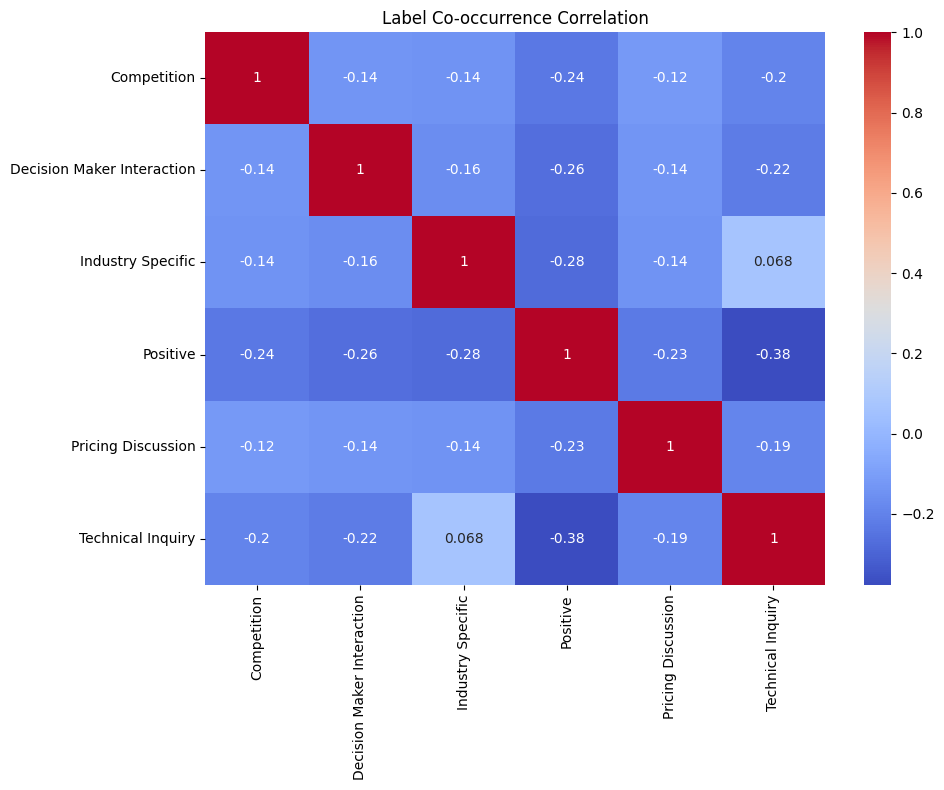

In [52]:
#Label Correlation Visualization
label_matrix = mlb.fit_transform(df['labels'].str.split(', '))
label_correlation = np.corrcoef(label_matrix.T)

plt.figure(figsize=(10, 8))
sns.heatmap(label_correlation,
            xticklabels=mlb.classes_,
            yticklabels=mlb.classes_,
            annot=True,
            cmap='coolwarm')
plt.title('Label Co-occurrence Correlation')
plt.tight_layout()
plt.show()

In [53]:
test_snippet = "We're comparing your pricing with CompetitorX's solution"
preprocessed_test = text_cleaner(test_snippet)
vectorized_test = vectorizer.transform([preprocessed_test])
label_probs = classifier.predict_proba(vectorized_test)[0]
labels_indices = np.where(label_probs > 0.5)[0]
predicted_labels = mlb.classes_[labels_indices]

print(f"Test Snippet: {test_snippet}")
print(f"Predicted Labels: {list(predicted_labels)}")

Test Snippet: We're comparing your pricing with CompetitorX's solution
Predicted Labels: ['Competition']


Task 2: Entity/Keyword Extraction with a Domain Knowledge Base

In [54]:
#importing relevanmt imports
import pandas as pd
import spacy
import json
import re
from typing import List, Dict, Tuple

In [55]:
#Load domain knowledge
with open('domain_knowledge.json', 'r') as f:
    domain_knowledge = json.load(f)

#Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [56]:
#Compile regex patterns for domain-specific extraction
competitors_pattern = r'\b(' + '|'.join(re.escape(comp) for comp in domain_knowledge['competitors']) + r')\b'
features_pattern = r'\b(' + '|'.join(re.escape(feat) for feat in domain_knowledge['features']) + r')\b'
pricing_pattern = r'\b(' + '|'.join(re.escape(kw) for kw in domain_knowledge['pricing_keywords']) + r')\b'
security_pattern = r'\b(' + '|'.join(re.escape(sec) for sec in domain_knowledge['security_keywords']) + r')\b'
pain_points_pattern = r'\b(' + '|'.join(re.escape(point) for point in domain_knowledge['pain_points']) + r')\b'
industry_pattern = r'\b(' + '|'.join(re.escape(ind) for ind in domain_knowledge['industry_verticals']) + r')\b'
decision_maker_pattern = r'\b(' + '|'.join(re.escape(role) for role in domain_knowledge['decision_maker_roles']) + r')\b'
technical_concerns_pattern = r'\b(' + '|'.join(re.escape(concern) for concern in domain_knowledge['technical_concerns']) + r')\b'

patterns = {
    'competitors': re.compile(competitors_pattern, re.IGNORECASE),
    'features': re.compile(features_pattern, re.IGNORECASE),
    'pricing': re.compile(pricing_pattern, re.IGNORECASE),
    'security': re.compile(security_pattern, re.IGNORECASE),
    'pain_points': re.compile(pain_points_pattern, re.IGNORECASE),
    'industries': re.compile(industry_pattern, re.IGNORECASE),
    'decision_makers': re.compile(decision_maker_pattern, re.IGNORECASE),
    'technical_concerns': re.compile(technical_concerns_pattern, re.IGNORECASE)
}

In [40]:
#Read dataset
df = pd.read_csv('calls_dataset.csv')

In [58]:
for index, row in df.iterrows():
    text = str(row['text_snippet'])

    # Domain-specific entity extraction
    domain_entities = {
        'competitors': patterns['competitors'].findall(text),
        'features': patterns['features'].findall(text),
        'pricing_keywords': patterns['pricing'].findall(text),
        'security_keywords': patterns['security'].findall(text),
        'pain_points': patterns['pain_points'].findall(text),
        'industries': patterns['industries'].findall(text),
        'decision_makers': patterns['decision_makers'].findall(text),
        'technical_concerns': patterns['technical_concerns'].findall(text)
    }
    domain_entities = {k: v for k, v in domain_entities.items() if v}

    #SpaCy NER entity extraction
    doc = nlp(text)
    ner_entities = {
        'PERSON': [ent.text for ent in doc.ents if ent.label_ == 'PERSON'],
        'ORG': [ent.text for ent in doc.ents if ent.label_ == 'ORG'],
        'GPE': [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    }
    ner_entities = {k: v for k, v in ner_entities.items() if v}

    #Combine entities
    combined_entities = {**domain_entities, **ner_entities}

    #Add entities to dataframe
    df.at[index, 'extracted_entities'] = json.dumps(combined_entities)

In [59]:
#Save processed dataset
df.to_csv('calls_dataset_with_entities.csv', index=False)

In [60]:
#Evaluation
total_snippets = len(df)
snippets_with_entities = sum(len(json.loads(entities)) > 0 for entities in df['extracted_entities'])
coverage = snippets_with_entities / total_snippets

print("Entity Extraction Evaluation:")
print(f"Total Snippets: {total_snippets}")
print(f"Snippets with Entities: {snippets_with_entities}")
print(f"Coverage: {coverage:.2%}")

Entity Extraction Evaluation:
Total Snippets: 200
Snippets with Entities: 181
Coverage: 90.50%
